## 10/26/2021
**Requirments:** Based on this I wanted to get a feel from you on which topics you would be more interested in.  In other words, this intro touched on multibody formulation, differential algebraic equations, and Julia packages. Given this, are you comfortable with Julia to write a small program in Julia to define:
The 3D motion (translation and rotation) of a rigid body using both Cardan and quaternion
* A joint formulation (e.g. revolute) joint
* You may use the DifferentialEquations package to help you solve the model
* It would be an asset to show both Cartesian and joint based formulation. 
 
In you work, show the different forms of equations and possible solution methods

**Purpose:** get familiar with the formulation of 3D body.  So basically write down the equations of motion using any principal you learned (like Newton-Euler, Lagrange, Hamilton) and use rotation parameters like Cardan/quaternion angles to define the motion of the body.  You could use ModelingToolkit to make it easier.  Then you could add equation of joint constraints to solve it all together.  This is basically to get you familiar with multibody formulation.

## Calculate rotation matrix R using three methods
Rotating around x axis(1,0,0) $\pi/4$, then rotating y axis, $\pi/4$, finally rotating z axis $\pi/4$
* **Method 1: Obtain rotation matrix using Euler and Cardan** (also inverse matrix)

In [1]:
using LinearAlgebra

In [2]:
using LinearAlgebra
function CardanR(x,y,z) #Euler method for rotating around x,y,z axis respectively to get the rotation matrix R
    Rx = [1 0 0;0 cos(x) -sin(x);0 sin(x) cos(x)]
    Ry = [cos(y) 0 sin(y);0 1 0;-sin(y) 0 cos(y)]
    Rz = [cos(z) -sin(z) 0;sin(z) cos(z) 0;0 0 1]
    return Rx*Ry*Rz
end
function InvCardanR(x,y,z) #Euler method for rotating around x,y,z axis respectively to get the rotation matrix R
    Rx = [1 0 0;0 cos(x) -sin(x);0 sin(x) cos(x)]
    Ry = [cos(y) 0 sin(y);0 1 0;-sin(y) 0 cos(y)]
    Rz = [cos(z) -sin(z) 0;sin(z) cos(z) 0;0 0 1]
    return inv(Rx*Ry*Rz)
end
#Roll-Pitch-Yaw for Euler angle
function InvR(x,y,z) #CardanR method for rotating around x,y,z axis respectively to get the rotation matrix R
    Rx = [1 0 0;0 cos(-x) -sin(-x);0 sin(-x) cos(-x)]
    Ry = [cos(-y) 0 sin(-y);0 1 0;-sin(-y) 0 cos(-y)]
    Rz = [cos(-z) -sin(-z) 0;sin(-z) cos(-z) 0;0 0 1]
    return inv(Rz*Ry*Rx)
end
# Here I used some weired cardamR matrix to get the correct result, which was supposed to be inv(R) only, however I used only the matrix itself
function weirdinvCardanR(x,y,z) #CardanR method for rotating around x,y,z axis respectively to get the rotation matrix R
    Rx = [1 0 0;0 cos(x) -sin(x);0 sin(x) cos(x)]
    Ry = [cos(y) 0 sin(y);0 1 0;-sin(y) 0 cos(y)]
    Rz = [cos(z) -sin(z) 0;sin(z) cos(z) 0;0 0 1]
    return inv(transpose(Rz*Ry*Rx))
end
# aa=CardanR(pi/4,0,pi/4)
# tr(CardanR(pi/2,pi/2,pi/2))
# aa
# InvR(1,0.5,0.3),InvCardanR(1,0.5,0.3)
# InvR(0,1,0)
# CardanR(0,1,0)

weirdinvCardanR (generic function with 1 method)

* **Method 2:Exponitial** (Just for practice, does not applied in the following code)

In [3]:
function ExptoR(omega,theta) #Expontial method for rotating around x,y,z axis respectively to get the rotation matrix R
    braketw=[0 -omega[3] omega[2]; omega[3] 0 -omega[1]; -omega[2] omega[1] 0]
    R=I(3)+sin(theta)*braketw+(1-cos(theta))*braketw^2
    return R
end
# ExptoR(bb[3],bb[1])

ExptoR (generic function with 1 method)

* **Function used in the following code:** <br>1. Bracket function for cross product<br>2. J function for Euler method (determine euler angle from body frame angular velocity p q r)<br> $[\dot{\Phi},\dot{\Theta},\dot{\Psi}]^T=J*[p,q,r]^T$ where $J = \begin{bmatrix}
1 & sin\phi tan\theta & cos\phi tan\theta\\
0 & cos\phi & -cos\phi\\
0 & sin\phi sec\theta & cos\phi sec\theta
\end{bmatrix}$
<br>3. Quaternion function for quaternion conversion (q to $\dot{q}$): input are p q r. which is
$\begin{bmatrix}
0 & -p & -q&-r \\
p & 0 & r&-q\\
q & -r & 0& p\\
r & q & -p&0
\end{bmatrix}$

In [4]:
#omega cross product x == braket omega dot product x
function bracket(omega)
    return [0 -omega[3] omega[2]; omega[3] 0 -omega[1]; -omega[2] omega[1] 0]
#     return [0 -omega[3] omega(2) v(1); omega(3) 0 -omega(1) v(2);-omega(2) omega(1) 0 v(3); 0 0 0 0]
end
#try to solve singularity at theta = 0, however seems doesnot work because of angle can not reach exactly 0(maybe 0.00000001 but not 0)
function FrontJ(euler)
#     if cos(euler[2]) == 0 #try to solve singularity at theta = 0
#         x = [1 sin(euler[1])*tan(euler[2]) cos(euler[1])*tan(euler[2]);0 cos(euler[1]) -sin(euler[1]);0 0 0]
#     else
        x = [1 sin(euler[1])*tan(euler[2]) cos(euler[1])*tan(euler[2]);0 cos(euler[1]) -sin(euler[1]);0 sin(euler[1])/cos(euler[2]) cos(euler[1])/cos(euler[2])]
    return x
end
#p=omega[1]  q= omega[2] r=omega[3] #braket for quaternion with p,q,r angular velocity as inputs 
function BraketQuart(omega)
    return [0 -omega[1] -omega[2] -omega[3]; omega[1] 0 omega[3] -omega[2]; omega[2] -omega[3] 0 omega[1]; omega[3] omega[2] -omega[1] 0]
end

BraketQuart (generic function with 1 method)

* **Converting rotataing matrix R back to theta and omega**
<br>$\theta=acos(0.5*(tr(R)-1))$
<br>$[w]=\frac{1}{2*sin\theta}(R-R^T)$
<br> As we know:
<br> For $\omega = \begin{bmatrix} \omega_1 \\ \omega_2 \\ \omega_3\end{bmatrix}$, Bracket $\omega$:
    $[\omega] = \begin{bmatrix} 0 & -\omega_3 & \omega_2 \\ \omega_3 & 0 & -\omega_1 \\ -\omega_2 & \omega_1 & 0\end{bmatrix}$. <br> 

In [5]:
function rotateRtotheta(R)#converting rotataing matrix back to theta and omega
    theta=acos(0.5*(tr(R)-1))
    braketw=1/(2*sin(theta))*(R-transpose(R))
    omega=[braketw[3,2],braketw[1,3],braketw[2,1]]
    return theta,braketw,omega
end
# bb=rotateRtotheta(aa)

rotateRtotheta (generic function with 1 method)

* **Method 3:Quaternion** (also inverse matrix)

$ q=a+bi +cj+dk =q_0 + q_1 i +q_2 j +q_3 k $ <br>

<br>
$v':$ Vector $v$ rorating $\theta$ along axis $u$ ; setting $a=cos(\frac{1}{2}\theta),b=sin(\frac{1}{2}\theta)u_x, c=sin(\frac{1}{2}\theta)u_y, d=sin(\frac{1}{2}\theta)u_z$<br> 
$ v'= R\cdot v$<br>
$R=\begin{bmatrix}q_0^2 + q_1^2 -q_2^2 -q_3^2& 2(q_1 q_2-q_0q_3) & 2(q_0 q_2+q_1 q_3)\\ 2(q_0 q_3+q_1 q_2) & q_0^2 - q_1^2 +q_2^2 -q_3^2 &  2(q_2 q_3-q_0 q_1)\\ 2(q_1 q_3-q_0 q_2) &  2(q_0 q_1+q_2 q_3) & q_0^2 - q_1^2 -q_2^2 +q_3^2\end{bmatrix}$

In [6]:
#Given omega and theta(which is the normalized rotating axis and rotating angle), output the corresponding quaternion format
function QuaternionQ(omega,theta) 
    q = [cos(theta/2) omega[1]*sin(theta/2) omega[2]*sin(theta/2) omega[3]*sin(theta/2)]
    R = [(q[1]^2)+(q[2]^2)-(q[3]^2)-(q[4]^2) 2*(q[2]*q[3]-q[1]*q[4]) 2*(q[1]*q[3]+q[2]*q[4]);
        2*(q[1]*q[4]+q[2]*q[3]) (q[1]^2)-(q[2]^2)+(q[3]^2)-(q[4]^2) 2*(q[3]*q[4]-q[1]*q[2]);
        2*(q[2]*q[4]-q[1]*q[3]) 2*(q[1]*q[2]+q[3]*q[4]) (q[1]^2)-(q[2]^2)-(q[3]^2)+(q[4]^2)]
    return q
end
#Given omega and theta(which is the normalized rotating axis and rotating angle), output the corresponding quaternion format
function QuaternionR(omega,theta)
    q = [cos(theta/2) omega[1]*sin(theta/2) omega[2]*sin(theta/2) omega[3]*sin(theta/2)]
    R = [(q[1]^2)+(q[2]^2)-(q[3]^2)-(q[4]^2) 2*(q[2]*q[3]-q[1]*q[4]) 2*(q[1]*q[3]+q[2]*q[4]);
        2*(q[1]*q[4]+q[2]*q[3]) (q[1]^2)-(q[2]^2)+(q[3]^2)-(q[4]^2) 2*(q[3]*q[4]-q[1]*q[2]);
        2*(q[2]*q[4]-q[1]*q[3]) 2*(q[1]*q[2]+q[3]*q[4]) (q[1]^2)-(q[2]^2)-(q[3]^2)+(q[4]^2)]
    return R
end

function InverseQuaternionR(q)
#     q = [cos(theta/2) omega[1]*sin(theta/2) omega[2]*sin(theta/2) omega[3]*sin(theta/2)]
    R = [(q[1]^2)+(q[2]^2)-(q[3]^2)-(q[4]^2) 2*(q[2]*q[3]-q[1]*q[4]) 2*(q[1]*q[3]+q[2]*q[4]);
        2*(q[1]*q[4]+q[2]*q[3]) (q[1]^2)-(q[2]^2)+(q[3]^2)-(q[4]^2) 2*(q[3]*q[4]-q[1]*q[2]);
        2*(q[2]*q[4]-q[1]*q[3]) 2*(q[1]*q[2]+q[3]*q[4]) (q[1]^2)-(q[2]^2)-(q[3]^2)+(q[4]^2)]
    return inv(R)
end
function QuaterniontoEuler(q)
#     q = [cos(theta/2) omega[1]*sin(theta/2) omega[2]*sin(theta/2) omega[3]*sin(theta/2)]
    Euler = [atan(2*(q[1]*q[2]+q[3]*q[4]),1-2*((q[2])^2+(q[3])^2)) asin(2*(q[1]*q[3]-q[4]*q[2])) atan(2*(q[1]*q[4]+q[2]*q[3]),1-2*((q[3])^2+(q[4])^2))]
    return Euler
end  

function weirdTransposeInvQuaternionR(q)#I call this weired because I applied a transpose before doing the inverse
#     q = [cos(theta/2) omega[1]*sin(theta/2) omega[2]*sin(theta/2) omega[3]*sin(theta/2)]
    R = [(q[1]^2)+(q[2]^2)-(q[3]^2)-(q[4]^2) 2*(q[2]*q[3]-q[1]*q[4]) 2*(q[1]*q[3]+q[2]*q[4]);
        2*(q[1]*q[4]+q[2]*q[3]) (q[1]^2)-(q[2]^2)+(q[3]^2)-(q[4]^2) 2*(q[3]*q[4]-q[1]*q[2]);
        2*(q[2]*q[4]-q[1]*q[3]) 2*(q[1]*q[2]+q[3]*q[4]) (q[1]^2)-(q[2]^2)-(q[3]^2)+(q[4]^2)]
    return inv(transpose(R))
end

function SecondQuaternionR(q)#this is wrong, this is for q1 i + q2 j + q3 k + q4, which is not the way we represent quaternion
#     q = [cos(theta/2) omega[1]*sin(theta/2) omega[2]*sin(theta/2) omega[3]*sin(theta/2)]
    R = [(q[1]^2)-(q[2]^2)-(q[3]^2)+(q[4]^2) 2*(q[1]*q[2]+q[3]*q[4]) 2*(q[1]*q[3]-q[2]*q[4]);
        2*(q[1]*q[2]-q[3]*q[4]) -(q[1]^2)+(q[2]^2)-(q[3]^2)+(q[4]^2) 2*(q[2]*q[3]+q[1]*q[4]);
        2*(q[2]*q[4]+q[1]*q[3]) 2*(q[2]*q[3]+q[1]*q[4]) -(q[1]^2)-(q[2]^2)+(q[3]^2)+(q[4]^2)]
    return R
end
# QuaternionR(bb[3],bb[1])

SecondQuaternionR (generic function with 1 method)

## To sum up
Comparing the rotation matrix from the three method: Just for testing if they are the same

In [7]:
# test function 
car=CardanR(pi/5,1.2,pi/3)
ang=rotateRtotheta(car)
ex=ExptoR(ang[3],ang[1])
qu=QuaternionR(ang[3],ang[1])
println("angle theta is ",ang[1])
println(car)
println(ex)
println(qu)

angle theta is 1.8731843145718488
[0.18117887723833684 -0.31381102063508376 0.9320390859672263; 0.9745486838678828 -0.069933846158658 -0.21298854413520565; 0.1320192304705377 0.9469064898338295 0.29315358141517367]
[0.18117887723833692 -0.31381102063508376 0.9320390859672263; 0.974548683867883 -0.06993384615865783 -0.2129885441352058; 0.13201923047053765 0.9469064898338295 0.29315358141517367]
[0.18117887723833698 -0.31381102063508365 0.9320390859672263; 0.9745486838678827 -0.06993384615865805 -0.2129885441352058; 0.13201923047053782 0.9469064898338295 0.2931535814151736]


## Start: rigid body dynamic
* Moi matrix function wrt center of mass for rectanglular

In [8]:
#moi matrix function for a block wrt center of mass function
I_brick(Lx,Ly,Lz,m)=[(m*(Ly^2 + Lz^2)/12) 0 0; 0 (m*(Lx^2 + Lz^2)/12) 0;0 0 (m*(Lx^2 + Ly^2)/12)]
# I_brick(1,2,1,1)

I_brick (generic function with 1 method)

Euler method:If the body-fixed frame is rotating with rotation vector $ω$, then for any vector, $a$,$\frac{d}{dt}a$ in the inertial frame is <br> $\frac{da}{dt}_{[inertia]} = \frac{da}{dt}_{[body]} +\omega \times a$ <br>  Therefore, we can have $F=m(\dot{V_b}+\omega \times V_b)$<br> and $M=\dot{H_b}+\omega \times H$ where $H=I\omega$
\begin{bmatrix}
i & j & k\\
p & q & r\\
u_b & v_b & w_b
\end{bmatrix}

* Linear momentum equation:
$\omega \times V_b = (qw_b-rv_b) i + (ru_b-pw_b) j +(pv_b-qu_b) k$
so emo becomes $\dot{V_b}=[\dot{u},\dot{v},\dot{w}]^T = \frac{1}{m}F_b-\omega \times V_b = [\frac{F_x}{m}- (qw_b-rv_b)] i + [\frac{F_y}{m}- (ru_b-pw_b)] j +[\frac{F_z}{m}- (pv_b-qu_b)] k$ 
<!-- $ i+  j+    k$ -->
<br>
* Angular momentum equation:
$\dot{\omega}=[\dot{p},\dot{q},\dot{r}]^T=I^{-1}(M-\omega \times (I\omega))$
<br> where F and M are the force and moment applied on the body fixed frame, if we are going to add extra forces (eg. gravaity) adding here.
<br>
* Rotate FROM the body-fixed coordinates to the inertial frame:
$\dot{X}=[\dot{x},\dot{y},\dot{z}]^T = R^{-1} [u,v,w]^T$

In [9]:
## Example of DifferentialEquations
# using DifferentialEquations
# using LinearAlgebra
using ModelingToolkit
# #u1=ub u2=vb u3=wb u4=p u5=q u6=r 
# function Euler3D!(du,u,MOI,F,M,t)
#     du[1] = F[1]/m-(u[5]*u[3]-u[6]*u[2])                    # θ'(t) = ω(t)
#     du[2] = F[2]/m-(u[6]*u[1]-u[4]*u[3]) 
#     du[3] = F[3]/m-(u[4]*u[2]-u[5]*u[1]) 
# #     du[2] = -3g/(2l)*sin(u[1]) + 3/(m*l^2)*p(t) # ω'(t) = -3g/(2l) sin θ(t) + 3/(ml^2)M(t)
# end
# θ₀ = 0.0                           # initial angular deflection [rad]
# ω₀ = 0.0                            # initial angular velocity [rad/s]
# u₀ = [θ₀, ω₀]   
# tspan = (0.0,1.0)
# prob = ODEProblem(f,u0,tspan)

## Solving using Euler Angle

In [ ]:
#use matrix method Euler
using DifferentialEquations
using LinearAlgebra
using Plots
# using LaTeXStrings
# using LatexStrings
#input
M = [2;1.5; 3] # Moment applied on the rigid body wrb to body frame
# M = [0;0;0]
# MOI=I(3)
F = [2.5; 3; 2] # Force applied on the rogod body wrb to body frame
m=2 #mass of the body = rho*V
MOI=[1 2.1 3;2 5 1;2.5 3 4]
#input end
InvMOI=inv(transpose(MOI))
#u1=ub u2=vb u3=wb u4=p u5=q u6=r u7=x u8=y u9=z u10=phiϕ u11=thetaΘ u12=psiΨ
# u13=x_i,u14=y_i,u15=z_i,u16=u_i,u17=v_i,u18=w_i

# function condition(u,t,warpangle) # Event when event_f(u,t) >pi #tried to wrap the angle to 2pi but does not work well
#   u[10]-pi
# end
# function affect!(warpangle)
#   warpangle.u[10] = warpangle.u[10]%pi
# end
# cb = ContinuousCallback(condition,affect!)

function Euler3D!(du,u,p,t)
    du[1:3]=F/m-bracket(u[4:6])*u[1:3]
    du[4:6]=InvMOI*(M-bracket(u[4:6])*(MOI*u[4:6]))
    du[7:9]=u[1:3]
    u[10]=((u[10]+pi)%(2*pi))-pi
    u[11]=((u[11]+pi)%(2*pi))-pi#u[11]%(2*pi)
    u[12]=((u[12]+pi)%(2*pi))-pi#u[12]%(2*pi)  #adjust the theta such that it never go beyond [-pi,pi], % is reminder
    du[10:12]=FrontJ(u[10:12])*u[4:6]
    du[13:15]=weirdinvCardanR(u[10],u[11],u[12])*u[1:3] #weirdinvCardanR
#     u[16:18]=weirdinvCardanR(u[10],u[11],u[12])*u[1:3]
    u[16:18]=du[13:15]
#     u[13:15]=InvCardanR(u[10],u[11],u[12])*u[7:9]
#   du .= u[:,2] .- 10 - M./C.*u[:,2] - M.\K.*u[:,1]
end
#initial condition input: change accordingly
v0=[2.0 3.0 1.0]#initial linear velocity body frame
w0=[0.8 0.5 1]#initial angular velocity rotation rate body frame
x0=[5.0 6.0 7.0] #initial position inertial frame
theta0=[-1 1.2 0.5]#initial Euler Angle [roll, pitch, yaw]
tspan=(0.0,2)#time span
#do not chang following 
x00=[0 0 0] #initial position body frame, no change alway [0,0,0]
v00=transpose(weirdinvCardanR(theta0[1],theta0[2],theta0[3])*transpose(v0))
u0=[v0 w0 x00 theta0 x0 v00]
prob=ODEProblem(Euler3D!,u0,tspan)
sol=solve(prob,reltol=1e-8,Tsit5())

# plot(sol)
# Tordius(x) = (180*x/pi)
a=plot(sol,vars=(0,[1,2,3]),title="Velocity wrb to body frame",labels=["u_b" "v_b" "w_b"],ylab = "V_b [m/s]",titlefontsize=8)
b=plot(sol,vars=(0,[4,5,6]),title="Angular velocity wrb to body frame",labels=["p" "q" "r"],ylab = "ω_b [rad/s]",titlefontsize=8)
c=plot(sol,vars=(0,[7,8,9]),title="Position wrb to body frame",ylab = "x_b [m]",titlefontsize=8)
d=plot(sol,vars=(0,[10,11,12]),title="Euler Angle (Cardan)",labels=["ϕ" "Θ" "Ψ"],ylab = "θ [rad]",titlefontsize=8)
e=plot(sol,vars=(0,[13,14,15]),title="Position wrb to inertia frame",labels=["x_i" "y_i" "z_i"],ylab = "x_i [m]",titlefontsize=8)
f=plot(sol,vars=(0,[16,17,18]),title="Velocity wrb to inertia frame",labels=["u_i" "v_i" "w_i"],ylab = "V_i [m/s]",titlefontsize=8)
# plot(a,b,d,f,layout=(2,2))
plot(plot(e,f,a,layout=(1,3),w=1),plot(d,b),layout=(2,1))
# plot(e)
# legend=["u_b","v_b","w_b"]
# ylabel!("My x label")

# plot(sol,vars=(0,1))
# plot(sol,vars=(1,2,3),linewidth=2,xaxis="t",label=["θ [rad]" "ω [rad/s]"],layout=(2,1))
# CardanR(u[10:12])*

# time=size(sol)
# sol[:,1]
# PinBody=sol[1,7:9,:]
# R=zeros(3, 3)
# x=zeros(time[3])
# y=zeros(time[3])
# z=zeros(time[3])
# for i=1:time[3]
#     R=CardanR(sol[10,i],sol[11,i],sol[12,i])
#     v=R*PinBody[:,i]
#     x[i]=v[1]
#     y[i]=v[2]
#     z[i]=v[3]
#     R=zeros(3,3)
# end
# plot(Base.range(0,2, length=time[3]),z)

* **Adding Constraints:**
Adding constraint can be achieved by setting parameter =0
<br> For example, we could set u[7]=0 , u[8]=0 or u[9]=0 at the end of the ode function to constraint the prismatic motion of the body.<br>Similarlar, u[10]=0 , u[11]=0 or u[12]=0 for rotational motion constraints
<br> (PS.not sure if this is the correct way adding constraints though, but it works during the test)

## Solving using Quaternion

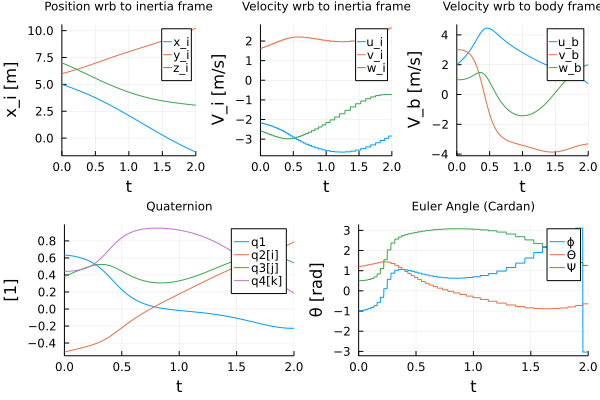

In [11]:
#use matrix method Quaternion
using DifferentialEquations
using LinearAlgebra
using Plots
# M = [5
#     2
#     2]
# F = [1
#     2
#     3]
#input:
# M = [0;0;0]
M = [2;1.5; 3]# Moment applied on the rogod body wrb to body frame
F = [2.5; 3; 2] # Force applied on the rogod body wrb to body frame
K=1 #K is the gain that control the solving speed, default to 1. large  K improves the decay rate of the error in the norm,
#but also slows the simulation because fast dynamics are introduced
m=2 #mass of the body = rho*V
# MOI=I(3)
MOI=[1 2.1 3;2 5 1;2.5 3 4]
#input end
InvMOI=inv(transpose(MOI))
#u1=ub u2=vb u3=wb u4=p u5=q u6=r u7=x_b(trival) u8=y_b u9=z_b u10=q1 
#u11=q2 u12=q3 u13=q4,u14=x_i,u15=y_i,u16=z_i,u17=u_i,u18=v_i,u19=w_i,u20=ϕ,u21=Θ,u22=Ψ
function Quaternion3D!(du,u,p,t)
    du[1:3]=F/m-bracket(u[4:6])*u[1:3]
    du[4:6]=InvMOI*(M-bracket(u[4:6])*(MOI*u[4:6]))
    du[7:9]=u[1:3]
    du[10:13]=(1/2)*BraketQuart(u[4:6])*u[10:13]+K*(1-(norm(u[10:13]))^2)*u[10:13]
    u[10:13]=u[10:13]/norm(u[10:13])#normolize the quaternion on every iteration
#     du[14:16]=InverseQuaternionR(u[10:13])*u[1:3] 
    du[14:16]=weirdTransposeInvQuaternionR(u[10:13])*u[1:3]
    u[17:19]=du[14:16]
    u[20:22]=QuaterniontoEuler(u[10:13])
#   du .= u[:,2] .- 10 - M./C.*u[:,2] - M.\K.*u[:,1]
end
v0=[2.0 3.0 1.0]#initial linear velocity body frame
w0=[0.8 0.5 1]#initial angular velocity rotation rate body frame
x0=[5.0 6.0 7.0] #initial position inertial frame
theta0=[-1 1.2 0.5]#initial Euler Angle [roll, pitch, yaw]
tspan=(0.0,2.0);#time span

# R_euler=CardanR(theta0[1],theta0[2],theta0[3])
R_euler=weirdinvCardanR(theta0[1],theta0[2],theta0[3])
oneang=rotateRtotheta(R_euler)
qu0=QuaternionQ(oneang[3],oneang[1])
x00=[0 0 0] #initial position body frame, alway [0,0,0]
v00=transpose(weirdinvCardanR(theta0[1],theta0[2],theta0[3])*transpose(v0))
# qu0=[1.0 0.0 0.0 0.0]#initial angle in quaternion
u0=[v0 w0 x00 qu0 x0 v00 theta0]
prob=ODEProblem(Quaternion3D!,u0,tspan)
sol=solve(prob,reltol=1e-8,Tsit5())
# plot(sol)
Tordius(x) = (180*x/pi)
# plot(sol,vars=(0,[1,2,3]),title="I Love DiffEqs!")
a=plot(sol,vars=(0,[1,2,3]),title="Velocity wrb to body frame",labels=["u_b" "v_b" "w_b"],ylab = "V_b [m/s]",titlefontsize=8)
b=plot(sol,vars=(0,[4,5,6]),title="Angular velocity wrb to body frame",labels=["p" "q" "r"],ylab = "ω_b [rad/s]",titlefontsize=8)
c=plot(sol,vars=(0,[7,8,9]),title="Position wrb to body frame",ylab = "x_b [m]",titlefontsize=8)
d=plot(sol,vars=(0,[10,11,12,13]),title="Quaternion",labels=["q1" "q2[i]" "q3[j]" "q4[k]"],ylab = "[1]",titlefontsize=8)
e=plot(sol,vars=(0,[14,15,16]),title="Position wrb to inertia frame",labels=["x_i" "y_i" "z_i"],ylab = "x_i [m]",titlefontsize=8)
f=plot(sol,vars=(0,[17,18,19]),title="Velocity wrb to inertia frame",labels=["u_i" "v_i" "w_i"],ylab = "V_i [m/s]",titlefontsize=8)
g=plot(sol,vars=(0,[20,21,22]),title="Euler Angle (Cardan)",labels=["ϕ" "Θ" "Ψ"],ylab = "θ [rad]",titlefontsize=8)
plot(plot(e,f,a,layout=(1,3),w=1),plot(d,g),layout=(2,1))
# g=plot(sol,vars=(0,[10,11,12]),title="Euler Angle",labels=["ϕ" "Θ" "Ψ"],ylab = "θ [rad]",titlefontsize=8)
# plot(a,b,d,f,layout=(2,2))

## END 
Followings are ju

In [12]:
# use matrix method test, testing
using DifferentialEquations
using LinearAlgebra
# M = [1,1,1]
# F = [1,1,1]
# C = 1
# function eq(du,u,F,M,t)
#     du[1:3]=-cross(u[1:3],F)
#     du[4:6]=-cross(u[4:6],M)
   
# #   du .= u[:,2] .- 10 - M./C.*u[:,2] - M.\K.*u[:,1]
# end
# u0=[1.0 1.0 1.0 1.0 1.0 1.0]
# tspan=(0.0,10.0);
# prob=ODEProblem(eq,u0,tspan)
# sol=solve(prob)

using DifferentialEquations
using LinearAlgebra
a=[3,4,5]
f(u,p,t) = 1.01*bracket(u)*a
u0 = [1/2,1/2,0]
tspan = (0.0,1.0)
prob = ODEProblem(f,u0,tspan)
sol = solve(prob, Tsit5(), reltol=1e-8, abstol=1e-8)
MOI=I(3)
InvMOI=inv(MOI)

LoadError: cannot define function f; it already has a value

In [13]:
# testing
using LinearAlgebra
p=[3,4,5]
v=[2,3,5]
cross(p,v),bracket(p)*v
InversJ([0,pi/2,0])

LoadError: UndefVarError: InversJ not defined

In [14]:
# testing
mm=[1,2,3]
kk=[1;2;3]
mm,kk
# type mm end
MM=I(3)
TEST=MM*kk
TEST,typeof(mm),typeof(kk),typeof(TEST)
# mm%2
zeros(3, 3)
zeros(size(PinBody)[2],size(PinBody)[1])
R=CardanR(sol[10,1],sol[11,1],sol[12,1])
R[1]*PinBody[:,1]
time[3]
a=R[1]*PinBody[:,1]
a[1]

LoadError: UndefVarError: PinBody not defined

In [15]:
# testing
# PinBody=sol[1,7:9,:]
R=zeros(3, 3)
x=zeros(time[3])
y=zeros(time[3])
z=zeros(time[3])
# aa=time[3]
for i=1:10
    R=CardanR(sol[10,i],sol[11,i],sol[12,i])
#     v=R[i]*PinBody[:,i]
#     x[i]=v[1]
#     y[i]=v[2]
#     z[i]=v[3]
    R=zeros(3,3)
end #CardanR may not correct
CardanR(1,2,3)

LoadError: MethodError: no method matching getindex(::typeof(time), ::Int64)

In [16]:
# testing
PinBody[:,11]
Base.range(0,2,length=100)
atan(1,-1)
aa=[1,2,3,1]
-aa
(norm(aa))^2
oneang[1]*oneang[3]
QuaternionR(oneang[3],oneang[1])
# InvR,weirdinvCardanR,InverseQuaternionR
[inv(weirdinvCardanR(theta0[1],theta0[2],theta0[3]));inv(InverseQuaternionR([qu0[1],qu0[2],qu0[3],qu0[4]]))]
[weirdinvCardanR(theta0[1],theta0[2],theta0[3]) inv(transpose(weirdinvCardanR(theta0[1],theta0[2],theta0[3])))]

LoadError: UndefVarError: PinBody not defined

In [17]:
# testing
c=[5 4 1;4 5 6;7 8 9]
[inv(c);inv(transpose(c))]

6×3 Matrix{Float64}:
 -0.5      -4.66667   3.16667
  1.0       6.33333  -4.33333
 -0.5      -2.0       1.5
 -0.5       1.0      -0.5
 -4.66667   6.33333  -2.0
  3.16667  -4.33333   1.5

**End**